In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from fbm import FBM
from arch import arch_model
from scipy.linalg import cholesky
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_csv("data/df.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [ ]:
def calculate_log_rv(df, price_col='Close', resample_freq='1D'):
    """
    Calcola la log realized volatility (log-RV) da dati ad alta frequenza.

    Args:
        df (pd.DataFrame): DataFrame con indice di tipo Datetime e colonna dei prezzi.
        price_col (str): Nome della colonna dei prezzi.
        resample_freq (str): Frequenza per il resampling (es. '1D', '4H', '1H').

    Returns:
        pd.Series: Serie della log realized volatility con timestamp.
    """

    log_returns = np.log(df[price_col]).diff().dropna()
    
    # 2. Eleva al quadrato i log-return
    squared_log_returns = log_returns**2
    
    # 3. Resample sommando i return al quadrato per ottenere la RV
    # Il timestamp viene mantenuto automaticamente come indice
    realized_variance = squared_log_returns.resample(resample_freq).sum()
    
    # 4. Calcola il logaritmo della RV, gestendo valori nulli o negativi
    log_realized_variance = np.log(realized_variance)
    
    # Rimuovi i valori infiniti o mancanti (es. weekend senza trading)
    log_realized_variance = log_realized_variance.replace([np.inf, -np.inf], np.nan).dropna()
    
    print(f"Calcolata log-RV per frequenza '{resample_freq}'. Trovate {len(log_realized_variance)} osservazioni.")
    return log_realized_variance

In [39]:
# Costruiamo i DataFrame

price_d = df['price'].resample('D').last()
price_h = df['price'].resample('H').last()
price_5m = df['price'].resample('5m').last()

lret_d = np.log(price_d).diff().dropna()
lret_h = np.log(price_h).diff().dropna()
lret_5m = np.log(price_5m).diff().dropna()



lrv_d = calculate_log_rv(df, price_col=['price'], resample_freq='1D').squeeze()
lrv_h = calculate_log_rv(df, price_col=['price'], resample_freq='1h').squeeze()
lrv_5m = calculate_log_rv(df, price_col=['price'], resample_freq='5min').squeeze()

/tmp/ipykernel_86951/2925399322.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  price_h = df['price'].resample('H').last()
/tmp/ipykernel_86951/2925399322.py:5: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  price_5m = df['price'].resample('5m').last()
/home/simonepsn/.local/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Calcolata log-RV per frequenza '1D'. Trovate 2519 osservazioni.
Calcolata log-RV per frequenza '1h'. Trovate 48859 osservazioni.
Calcolata log-RV per frequenza '5min'. Trovate 520532 osservazioni.


/home/simonepsn/.local/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/simonepsn/.local/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [49]:
# GARCH(1,1)

def estimate_garch(log_returns_series):
    """
    Stima un modello GARCH(1,1) sui log-return.

    Args:
        log_returns_series (pandas.Series): Serie di log-return giornalieri.

    Returns:
        arch.univariate.base.ARCHModelResult: Oggetto risultato del modello fittato.
    """
    # Usiamo i return per stimare il GARCH, non la log-RV
    # Moltiplichiamo per 100 per stabilità numerica, una pratica comune
    model = arch_model(log_returns_series * 100, vol='Garch', p=1, q=1, dist='Normal')
    model_fit = model.fit(disp='off')
    return model_fit

def forecast_garch(model_fit, horizon, last_known_date, freq):
    """
    Esegue una previsione di 'horizon' passi per la varianza e
    restituisce una Series con indice temporale.
    """
    # Esegue il forecast
    forecast = model_fit.forecast(horizon=horizon, reindex=False)
    
    # Estrae i valori numerici della previsione
    predicted_variances_values = forecast.variance.iloc[0].values
    
    # Calcola la log-varianza
    log_predicted_variances = np.log(predicted_variances_values / (100**2))
    
    # Crea un indice di date future partendo dall'ultimo giorno conosciuto
    forecast_index = pd.date_range(start=last_known_date, periods=horizon + 1, freq=freq, inclusive='right')
    
    # Restituisce una Serie di pandas con i dati e l'indice corretto
    return pd.Series(log_predicted_variances, index=forecast_index, name='garch_forecast')

/home/simonepsn/.local/lib/python3.13/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03423. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


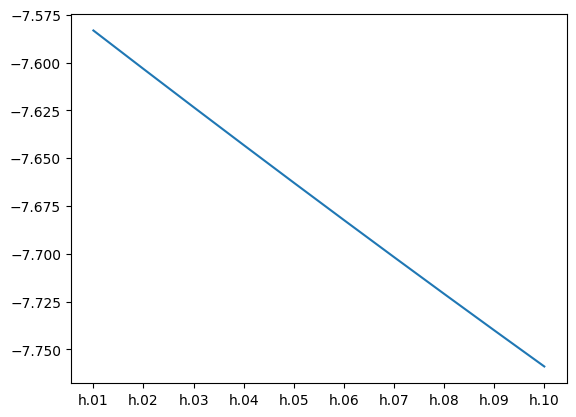

In [48]:
# Estimate GARCH(1,1)

garch_d = estimate_garch(lret_d)
garch_h = estimate_garch(lret_h)
garch_5m = estimate_garch(lret_5m)

forecast_garch_d = forecast_garch(garch_d, horizon=10)
forecast_garch_h = forecast_garch(garch_h, horizon=80)
forecast_garch_5m = forecast_garch(garch_5m, horizon=960)

plt.plot(forecast_garch_d)

In [51]:
# HAR

def prepare_har_data(log_rv_series, freq='D'):
    """
    Prepara il DataFrame per il modello HAR per diverse frequenze di dati.
    """
    # Aggiungiamo un controllo per l'input per evitare l'errore
    if not isinstance(log_rv_series, pd.Series):
        raise TypeError(f"L'input 'log_rv_series' deve essere una Serie di pandas, non {type(log_rv_series)}")

    if freq == 'D':
        periods_in_day = 1
    elif freq == 'H':
        periods_in_day = 24
    elif freq == '5min':
        periods_in_day = 24 * 12
    else:
        raise ValueError("Frequenza non supportata. Usa 'D', 'H', or '5min'.")
    
    weekly_window = periods_in_day * 5
    monthly_window = periods_in_day * 22
    
    df = pd.DataFrame({'log_rv': log_rv_series})
    
    df['daily_lag'] = df['log_rv'].shift(1)
    df['weekly_lag'] = df['log_rv'].rolling(window=weekly_window).mean().shift(1)
    df['monthly_lag'] = df['log_rv'].rolling(window=monthly_window).mean().shift(1)
    
    df.dropna(inplace=True)
    return df

def estimate_har(har_data):
    """
    Stima il modello HAR-RV usando OLS.

    Args:
        har_data (pandas.DataFrame): Dati preparati dalla funzione prepare_har_data.

    Returns:
        statsmodels.regression.linear_model.RegressionResultsWrapper: Risultato del modello fittato.
    """
    X = har_data[['daily_lag', 'weekly_lag', 'monthly_lag']]
    X = sm.add_constant(X) # Aggiunge l'intercetta
    y = har_data['log_rv']
    
    model = sm.OLS(y, X)
    model_fit = model.fit()
    return model_fit

def forecast_har_iterative(model_fit, latest_lags, horizon, last_known_date, freq):
    """
    Esegue una previsione iterativa di 'horizon' passi per il modello HAR
    e restituisce una Series con indice temporale.
    """
    # La logica interna per calcolare le previsioni rimane la stessa...
    current_lags = latest_lags.copy()
    predictions = []
    # (le finestre andrebbero passate o definite qui per robustezza)
    weekly_window = 5 
    monthly_window = 22

    for _ in range(horizon):
        X_forecast = pd.DataFrame([current_lags])
        X_forecast = sm.add_constant(X_forecast, has_constant='add')
        next_pred = model_fit.predict(X_forecast).iloc[0]
        predictions.append(next_pred)
        
        new_daily_val = next_pred
        new_weekly_lag = (current_lags['daily_lag'] * (weekly_window - 1) + new_daily_val) / weekly_window
        new_monthly_lag = (current_lags['weekly_lag'] * (monthly_window - 1) + new_daily_val) / monthly_window
        
        current_lags = pd.Series({
            'daily_lag': new_daily_val,
            'weekly_lag': new_weekly_lag,
            'monthly_lag': new_monthly_lag
        })
        
    # Crea un indice di date future
    forecast_index = pd.date_range(start=last_known_date, periods=horizon + 1, freq=freq, inclusive='right')
    
    # Restituisce una Serie di pandas
    return pd.Series(predictions, index=forecast_index, name='har_forecast')

In [53]:
# Estimate and forecast HAR

har_d_data = prepare_har_data(lrv_d, freq='D')
har_h_data = prepare_har_data(lrv_h, freq='H')
har_5m_data = prepare_har_data(lrv_5m, freq='5min')

har_d = estimate_har(har_d_data)
har_h = estimate_har(har_h_data)
har_5m = estimate_har(har_5m_data)

latest_lags_d = har_d_data.iloc[-1][['daily_lag', 'weekly_lag', 'monthly_lag']]
latest_lags_h = har_h_data.iloc[-1][['daily_lag', 'weekly_lag', 'monthly_lag']]
latest_lags_5m = har_5m_data.iloc[-1][['daily_lag', 'weekly_lag', 'monthly_lag']]

last_date_d = har_d_data.index[-1]
last_date_h = har_h_data.index[-1]
last_date_5m = har_5m_data.index[-1]

forecast_har_d = forecast_har_iterative(har_d, latest_lags_d, horizon=10, last_known_date=last_date_d, freq='D')
forecast_har_h = forecast_har_iterative(har_h, latest_lags_h, horizon=10, last_known_date=last_date_h, freq='h')
forecast_har_5m = forecast_har_iterative(har_5m, latest_lags_5m, horizon=10, last_known_date=last_date_5m, freq='5min')

In [ ]:
# RFSV - il metodo ACF non funziona per qualche strano motivo, va citato comunque

def theoretical_acf(h, n_lags):
    """Calcola l'ACF teorica per un processo fBm."""
    lags = np.arange(1, n_lags + 1)
    # Formula dell'autocovarianza per un fBm incrementale
    autocov = 0.5 * (np.abs(lags - 1)**(2*h) - 2 * np.abs(lags)**(2*h) + np.abs(lags + 1)**(2*h))
    return autocov

def est_parameters(log_rv_series, max_lags=100):
    """
    Stima l'esponente di Hurst H e la vol-of-vol nu.

    Args:
        log_rv_series (pandas.Series): Serie della log realized variance.
        max_lags (int): Numero di lag da usare per il matching dell'ACF.

    Returns:
        tuple: (h_estimated, nu_estimated)
    """
    # 1. Stima di H
    empirical_acf_vals = acf(log_rv_series, nlags=max_lags, fft=True)[1:]
    
    def objective_function(h):

        theoretical_acf_vals = theoretical_acf(h[0], max_lags)
        # Minimizza la somma dei quadrati degli errori
        return np.sum((empirical_acf_vals - theoretical_acf_vals)**2)

    # Esegui la minimizzazione per trovare H
    # Usiamo un valore iniziale ragionevole per H (es. 0.1)
    result = minimize(objective_function, x0=[0.1], bounds=[(0.01, 10)])
    h_estimated = result.x[0]

    # 2. Stima di nu
    # Var(log_sigma_t) = nu^2 * t^(2H)
    # Per t=1 (passo giornaliero), Var(log_RV) ≈ nu^2
    # Quindi, nu ≈ std(log_RV)
    nu_estimated = np.std(log_rv_series)
    
    return h_estimated, nu_estimated

In [ ]:
# il metodo Log-Log funziona invece e stima bene H

def estimate_h_loglog(series, scales, q=1):
    """
    Stima l'esponente di Hurst H usando una regressione log-log sui momenti.

    Args:
        series (pd.Series): La serie temporale (preferibilmente detrendizzata).
        scales (list of int): Lista di scale temporali (lag) da analizzare.
        q (int): L'ordine del momento da usare (solitamente 1 o 2).

    Returns:
        tuple: (H_stimato, R_squared)
    """
    moments = []
    for tau in scales:
        # Calcola gli incrementi sulla scala 'tau' e rimuovi i NaN
        increments = series.diff(tau).dropna()
        # Calcola il momento di ordine q
        moment = np.mean(np.abs(increments)**q)
        moments.append(moment)
    
    # Prepara i dati per la regressione log-log
    log_tau = np.log(scales)
    log_moments = np.log(moments)
    
    # Aggiungi una costante per l'intercetta della regressione
    X = sm.add_constant(log_tau)
    y = log_moments
    
    # Esegui la regressione lineare (OLS)
    model = sm.OLS(y, X)
    results = model.fit()
    
    # La pendenza è il coefficiente di log_tau
    slope = results.params[1]
    
    # Ricava H dalla pendenza
    h_estimated = slope / q
    
    return h_estimated, results.rsquared

In [ ]:
def build_fbm_covariance_matrix(times, h):
    """
    Costruisce la matrice di covarianza per un fBm ai tempi specificati.

    Args:
        times (np.array): Array di istanti temporali.
        h (float): Esponente di Hurst.

    Returns:
        np.array: Matrice di covarianza.
    """
    n = len(times)
    cov_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            t_i = times[i]
            t_j = times[j]
            cov_matrix[i, j] = 0.5 * (
                np.power(t_i, 2 * h) + 
                np.power(t_j, 2 * h) - 
                np.power(np.abs(t_i - t_j), 2 * h)
            )
    return cov_matrix

def forecast_RFSV(past_log_rv_series, h, nu, horizon, n_sims=1):
    """
    Esegue una previsione condizionale per il modello RFSV.

    Args:
        past_log_rv_series (pd.Series): Serie storica di log-RV.
        h (float): Esponente di Hurst.
        nu (float): Vol-of-vol.
        horizon (int): Orizzonte di previsione.
        n_sims (int): Numero di percorsi futuri da simulare.

    Returns:
        np.array: Matrice di previsioni (n_sims, horizon). 
                  Se n_sims=1, restituisce la media condizionale.
    """
    n_past = len(past_log_rv_series)
    
    # Definisci gli istanti temporali per il passato e il futuro
    past_times = np.arange(1, n_past + 1)
    future_times = np.arange(n_past + 1, n_past + horizon + 1)
    all_times = np.concatenate([past_times, future_times])

    # 1. Costruisci la matrice di covarianza globale (per W, non per log_sigma)
    # la covarianza del processo log_sigma è nu^2 * Cov(W)
    cov_global = build_fbm_covariance_matrix(all_times, h)
    
    # 2. Partiziona la matrice
    sigma_pp = cov_global[:n_past, :n_past]
    sigma_ff = cov_global[n_past:, n_past:]
    sigma_fp = cov_global[n_past:, :n_past]
    sigma_pf = sigma_fp.T

    # 3. Calcola i componenti per la media e covarianza condizionali
    # È la parte computazionalmente più costosa: inversione di sigma_pp
    try:
        sigma_pp_inv = np.linalg.inv(sigma_pp)
    except np.linalg.LinAlgError:
        # Usa la pseudo-inversa se la matrice è singolare
        sigma_pp_inv = np.linalg.pinv(sigma_pp)

    # Il processo che osserviamo è log_sigma = nu * W
    # Quindi, il passato osservato di W è W_p = past_log_rv_series / nu
    past_W = past_log_rv_series.values / nu
    
    # Media condizionale (per il processo W)
    mean_cond_W = sigma_fp @ sigma_pp_inv @ past_W
    
    # Covarianza condizionale (per il processo W)
    cov_cond_W = sigma_ff - sigma_fp @ sigma_pp_inv @ sigma_pf
    
    # 4. Simula dal processo condizionale
    # Se n_sims > 1, campiona. Altrimenti, restituisci solo la media.
    if n_sims > 1:
        # Usa Cholesky decomposition
        L = cholesky(cov_cond_W + np.eye(horizon) * 1e-8, lower=True)
        
        z = np.random.normal(size=(horizon, n_sims))
        
        simulated_paths_W = mean_cond_W[:, np.newaxis] + L @ z
        # Riconverti in percorsi di log_sigma
        simulated_paths_log_sigma = nu * simulated_paths_W.T
        return simulated_paths_log_sigma
    else:
        
        mean_forecast_log_sigma = nu * mean_cond_W
        return mean_forecast_log_sigma.reshape(1, -1)

In [ ]:
scales = [1, 2, 5, 10, 20, 50, 100, 200]

h_est_d, r_squared_d = estimate_h_loglog(lrv_d, scales, q=1)
h_est_h, r_squared_h = estimate_h_loglog(lrv_h, scales, q=1)
h_est_5m, r_squared_5m = estimate_h_loglog(lrv_5m, scales, q=1)

nu_est_d = lrv_d.std().iloc[0]
nu_est_h = lrv_h.std().iloc[0]
nu_est_5m = lrv_5m.std().iloc[0]

print("1 day:",h_est_d, r_squared_d, nu_est_d)
print("1 hour:", h_est_h, r_squared_h, nu_est_h)
print("5 minutes", h_est_5m, r_squared_5m, nu_est_5m)

In [ ]:
forecast_rfsv_d = forecast_RFSV(lrv_d, h_est_d, nu_est_d, horizon=10, n_sims=5)
forecast_rfsv_h = forecast_RFSV(lrv_h, h_est_h, nu_est_h, horizon=10, n_sims=5)
forecast_rfsv_5m = forecast_RFSV(lrv_5m, h_est_5m, nu_est_5m, horizon=10, n_sims=5)

In [ ]:
def qlike_loss(y_true, y_pred):
    """Calcola la loss function QLIKE."""
    # QLIKE è definita su RV, non su log-RV
    # Dobbiamo riconvertire le previsioni e i valori reali
    rv_true = np.exp(y_true)
    rv_pred = np.exp(y_pred)
    return np.mean(rv_pred / rv_true - np.log(rv_pred / rv_true) - 1)

def calculate_metrics(y_true, y_pred):
    """
    Calcola e stampa le metriche di performance.

    Args:
        y_true (list or np.array): Valori reali di log-RV.
        y_pred (list or np.array): Valori previsti di log-RV.

    Returns:
        dict: Dizionario con le metriche calcolate.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'QLIKE': qlike_loss(y_true, y_pred)
    }
    return metrics

In [ ]:
sim_df_D = pd.DataFrame({"log_vol_sim": lrv_d, 'lvol': lrv_d})

sim_df.set_index(lvol.index, inplace=True)

plt.plot(sim_df)


In [ ]:
sm.graphics.tsa.plot_acf(results['lvol'].dropna(), lags=40, label='Empirical')
sm.graphics.tsa.plot_acf(sim, lags=40, color='red', label='Simulated')

In [ ]:
f_emp, Pxx_emp = periodogram(results['lvol'].dropna())
f_sim, Pxx_sim = periodogram(simulated_log_vol)
plt.loglog(f_emp, Pxx_emp, label='Empirical')
plt.loglog(f_sim, Pxx_sim, label='Simulated')
plt.show()

In [ ]:
lags = np.arange(1, 31)
mean_abs_diffs = []

for h in lags:
    diffs = sim.shift(-h) - sim
    abs_diffs = np.abs(diffs.dropna())
    mean_abs_diffs.append(abs_diffs.mean())

log_lags = np.log(lags)
log_diffs = np.log(mean_abs_diffs)

short_lags = log_lags[:10]
short_diffs = log_diffs[:10]

slope, intercept, r_value, p_value, std_err = linregress(log_lags, log_diffs)

print(f"Estimated H from scaling law: {slope:.3f}")

In [ ]:
vol2obs = results['lvol'].diff().abs().dropna()
vol2sim = results['roughsim'].diff().abs().dropna()

HISTOGRAMS

plt.figure(figsize=(12, 6))
plt.hist(vol2obs, bins=100, alpha=0.5, label='Observed Volatility Changes', density=True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(vol2sim, bins=100, alpha=0.5, label='Simulated Volatility Changes', density=True)
plt.legend()
plt.show()

QQPLOT

sm.qqplot(vol2obs, line='s', label='Observed Volatility Changes')
sm.qqplot(vol2sim, line='s', label='Simulated Volatility Changes')
plt.legend()
plt.title('QQ Plot of Volatility Changes')
plt.show()

In [ ]:
dfgpt = pd.DataFrame({'sim': sim, 'lvol': lvol})

dfgpt.to_csv('data/dfgpt.csv')
